In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

In [2]:
#MAKE_PLOTS = True
#MAKE_PAIRPLOT = True
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_MAX = 100_000    # for outliers
#WEIGHT_TRESHOLD = 50        # for outliers
#NUM_OF_HOURS = 12
#SEED = 42
SHOW_ALL_WARNINGS = False
SHOW_ONLY_ONE_WARNING = False

In [3]:
import warnings

if SHOW_ONLY_ONE_WARNING:
    warnings.filterwarnings(action='once')
elif not SHOW_ALL_WARNINGS:
    warnings.filterwarnings('ignore')

In [4]:
sessions_df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2022-04-03 05:57:41,102,1155,VIEW_PRODUCT,10.0,NaN
1,124,2022-04-03 05:57:53,102,1156,VIEW_PRODUCT,10.0,NaN
2,124,2022-04-03 05:58:33,102,1160,VIEW_PRODUCT,10.0,NaN
3,124,2022-04-03 05:59:09,102,1159,VIEW_PRODUCT,10.0,NaN
4,124,2022-04-03 06:00:50,102,1158,VIEW_PRODUCT,10.0,NaN
...,...,...,...,...,...,...,...
101267,22735,2021-10-11 02:36:04,501,1005,VIEW_PRODUCT,15.0,NaN
101268,22735,2021-10-11 02:39:42,501,1001,VIEW_PRODUCT,15.0,NaN
101269,22735,2021-10-11 02:43:51,501,1003,VIEW_PRODUCT,15.0,NaN
101270,22735,2021-10-11 02:48:07,501,1009,VIEW_PRODUCT,15.0,NaN


## adding a column with time of delivery

In [5]:
# 1. Change format to datetime

deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 2. Add column time_of_delivery
deliveries_df["time_of_delivery"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 3. Delete not delivered products
deliveries_df = deliveries_df[deliveries_df["time_of_delivery"].notna()]

# 4. Set time_of_delivery as seconds
deliveries_df["time_of_delivery"] = deliveries_df["time_of_delivery"].apply(datetime.timedelta.total_seconds)


## join tables

In [6]:
# join rows where event_type is equal "BUY_PRODUCT"
# df.loc[df['col1'] == value]
sessions_df = sessions_df.loc[sessions_df["event_type"] == "BUY_PRODUCT"]
df = sessions_df.merge(products_df, on="product_id", how="left")
df = df.merge(deliveries_df, on="purchase_id", how="right")
df = df.merge(users_df, on="user_id", how="left")


df.to_csv('rrr.csv', 'w')
df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price,brand,weight_kg,optional_attributes,purchase_timestamp,delivery_timestamp,delivery_company,time_of_delivery,name,city,street
0,124,2022-04-03 06:12:00,102,1154,BUY_PRODUCT,10.0,20001.0,Słuchawki bezprzewodowe nauszne ASUS Rog Strix...,Mikrofony i słuchawki;Słuchawki bezprzewodowe,655.30,ASUS,0.880,{'color': 'czarny'},2022-04-03 06:12:00,2022-04-06 06:16:53,620,259493.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64
1,125,2022-04-10 10:59:49,102,1095,BUY_PRODUCT,20.0,20002.0,Kabel DisplayPort Unitek C1608BNI czarny 2m,Kable i przedłużacze;DisplayPort,58.99,Unitek,0.055,{},2022-04-10 10:59:49,2022-04-14 11:00:26,360,345637.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64
2,126,2021-03-16 17:25:30,102,1606,BUY_PRODUCT,5.0,20003.0,"Tablet Lenovo Tab M10 10.1"" 3 GB / 2 GB czarny",Tablety;Urządzenia,689.00,Lenovo,0.480,{'color': 'czarny'},2021-03-16 17:25:30,2021-03-18 17:27:39,516,172929.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64
3,128,2019-10-03 21:39:33,102,1608,BUY_PRODUCT,15.0,20004.0,Gogle VR Esperanza VR3DEAPSTD$VRPILOTBT,Urządzenia VR;Gogle VR,59.00,Esperanza,0.200,{},2019-10-03 21:39:33,2019-10-06 21:42:57,516,259404.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64
4,129,2019-10-20 02:13:14,102,1598,BUY_PRODUCT,20.0,20005.0,Skaner Brother ADS-2400N,Skanery;Profesjonalne,680.00,Brother,6.200,{},2019-10-20 02:13:14,2019-10-25 02:17:16,516,432242.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14697,22729,2021-09-27 18:17:04,501,1598,BUY_PRODUCT,0.0,34698.0,Skaner Brother ADS-2400N,Skanery;Profesjonalne,680.00,Brother,6.200,{},2021-09-27 18:17:04,2021-09-30 18:18:41,620,259297.0,Dawid Kocaj,Poznań,ulica Strażacka 082
14698,22731,2019-10-25 10:42:31,501,1032,BUY_PRODUCT,15.0,34699.0,Kamera internetowa Creative Live! Cam Sync 2 MP,"Akcesoria (Laptop, PC);Kamery internetowe",199.99,Creative,0.205,{},2019-10-25 10:42:31,2019-10-28 10:44:09,360,259298.0,Dawid Kocaj,Poznań,ulica Strażacka 082
14699,22732,2021-06-09 05:43:02,501,1474,BUY_PRODUCT,20.0,34700.0,Pendrive GOODRAM UME2-0320Y0R11 32 GB,Pamięci przenośne;Pendrive,14.60,GOODRAM,0.010,{'color': 'żółty'},2021-06-09 05:43:02,2021-06-14 05:44:14,516,432072.0,Dawid Kocaj,Poznań,ulica Strażacka 082
14700,22733,2019-11-03 09:34:50,501,1119,BUY_PRODUCT,10.0,34701.0,Klawiatura mechaniczna Razer BlackWidow V3 Ten...,Klawiatury;Przewodowe,440.00,Razer,1.720,{'color': 'czarny'},2019-11-03 09:34:50,2019-11-06 09:38:58,620,259448.0,Dawid Kocaj,Poznań,ulica Strażacka 082


## add column with information about returning - 0/1

In [7]:
sessions_df_2 = pd.read_json("data/sessions.jsonl", lines=True)
sessions_df_2 = sessions_df_2.loc[sessions_df_2["event_type"] == "RETURN_PRODUCT"]
sessions_df_2 = sessions_df_2.drop(columns=["session_id", "timestamp", "user_id", "product_id", "offered_discount"])

sessions_df_2.rename(columns = {'event_type':'return_label'}, inplace = True)
df = df.merge(sessions_df_2, on="purchase_id", how="left")

df['return_label'] = df['return_label'].replace(np.nan, 0)
df['return_label'] = df['return_label'].replace("RETURN_PRODUCT", 1)

df.to_json('rrr.json')
df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price,...,weight_kg,optional_attributes,purchase_timestamp,delivery_timestamp,delivery_company,time_of_delivery,name,city,street,return_label
0,124,2022-04-03 06:12:00,102,1154,BUY_PRODUCT,10.0,20001.0,Słuchawki bezprzewodowe nauszne ASUS Rog Strix...,Mikrofony i słuchawki;Słuchawki bezprzewodowe,655.30,...,0.880,{'color': 'czarny'},2022-04-03 06:12:00,2022-04-06 06:16:53,620,259493.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
1,125,2022-04-10 10:59:49,102,1095,BUY_PRODUCT,20.0,20002.0,Kabel DisplayPort Unitek C1608BNI czarny 2m,Kable i przedłużacze;DisplayPort,58.99,...,0.055,{},2022-04-10 10:59:49,2022-04-14 11:00:26,360,345637.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
2,126,2021-03-16 17:25:30,102,1606,BUY_PRODUCT,5.0,20003.0,"Tablet Lenovo Tab M10 10.1"" 3 GB / 2 GB czarny",Tablety;Urządzenia,689.00,...,0.480,{'color': 'czarny'},2021-03-16 17:25:30,2021-03-18 17:27:39,516,172929.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
3,128,2019-10-03 21:39:33,102,1608,BUY_PRODUCT,15.0,20004.0,Gogle VR Esperanza VR3DEAPSTD$VRPILOTBT,Urządzenia VR;Gogle VR,59.00,...,0.200,{},2019-10-03 21:39:33,2019-10-06 21:42:57,516,259404.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
4,129,2019-10-20 02:13:14,102,1598,BUY_PRODUCT,20.0,20005.0,Skaner Brother ADS-2400N,Skanery;Profesjonalne,680.00,...,6.200,{},2019-10-20 02:13:14,2019-10-25 02:17:16,516,432242.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14697,22729,2021-09-27 18:17:04,501,1598,BUY_PRODUCT,0.0,34698.0,Skaner Brother ADS-2400N,Skanery;Profesjonalne,680.00,...,6.200,{},2021-09-27 18:17:04,2021-09-30 18:18:41,620,259297.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0
14698,22731,2019-10-25 10:42:31,501,1032,BUY_PRODUCT,15.0,34699.0,Kamera internetowa Creative Live! Cam Sync 2 MP,"Akcesoria (Laptop, PC);Kamery internetowe",199.99,...,0.205,{},2019-10-25 10:42:31,2019-10-28 10:44:09,360,259298.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0
14699,22732,2021-06-09 05:43:02,501,1474,BUY_PRODUCT,20.0,34700.0,Pendrive GOODRAM UME2-0320Y0R11 32 GB,Pamięci przenośne;Pendrive,14.60,...,0.010,{'color': 'żółty'},2021-06-09 05:43:02,2021-06-14 05:44:14,516,432072.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0
14700,22733,2019-11-03 09:34:50,501,1119,BUY_PRODUCT,10.0,34701.0,Klawiatura mechaniczna Razer BlackWidow V3 Ten...,Klawiatury;Przewodowe,440.00,...,1.720,{'color': 'czarny'},2019-11-03 09:34:50,2019-11-06 09:38:58,620,259448.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5E4EEF648>]],
      dtype=object)

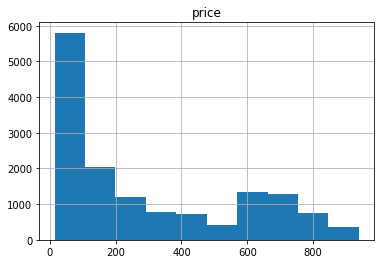

In [8]:
to_show_price_df = df[df["price"] <= PRICE_MAX]
to_show_price_df = to_show_price_df[to_show_price_df["price"] > 0]
to_show_price_df.hist(column="price")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5E4FB40C8>]],
      dtype=object)

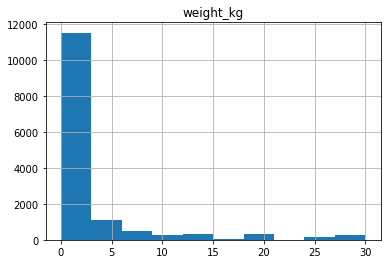

In [9]:
to_show_weight_df = df
to_show_weight_df = to_show_weight_df[to_show_weight_df["weight_kg"] <= 50]

to_show_weight_df.hist(column="weight_kg")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5E5008E08>]],
      dtype=object)

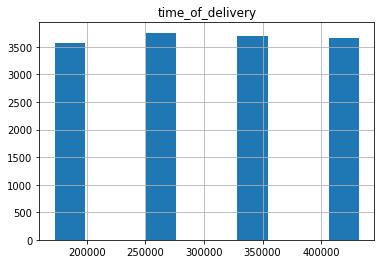

In [10]:
df.hist(column="time_of_delivery")

## 

In [11]:
def update_list_of_columns():
    banned_list_of_columns = [ ]
    columns_list = [col for col in df.columns.values.tolist() if col not in banned_list_of_columns]
    return columns_list

columns_list = update_list_of_columns()
columns_list

['session_id',
 'timestamp',
 'user_id',
 'product_id',
 'event_type',
 'offered_discount',
 'purchase_id',
 'product_name',
 'category_path',
 'price',
 'brand',
 'weight_kg',
 'optional_attributes',
 'purchase_timestamp',
 'delivery_timestamp',
 'delivery_company',
 'time_of_delivery',
 'name',
 'city',
 'street',
 'return_label']

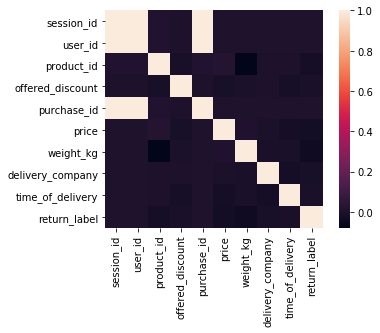

In [12]:
#sns.heatmap(df[columns_list].corr('spearman'));
sns.heatmap(df[columns_list].corr('pearson'), square=True)

In [13]:
df

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price,...,weight_kg,optional_attributes,purchase_timestamp,delivery_timestamp,delivery_company,time_of_delivery,name,city,street,return_label
0,124,2022-04-03 06:12:00,102,1154,BUY_PRODUCT,10.0,20001.0,Słuchawki bezprzewodowe nauszne ASUS Rog Strix...,Mikrofony i słuchawki;Słuchawki bezprzewodowe,655.30,...,0.880,{'color': 'czarny'},2022-04-03 06:12:00,2022-04-06 06:16:53,620,259493.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
1,125,2022-04-10 10:59:49,102,1095,BUY_PRODUCT,20.0,20002.0,Kabel DisplayPort Unitek C1608BNI czarny 2m,Kable i przedłużacze;DisplayPort,58.99,...,0.055,{},2022-04-10 10:59:49,2022-04-14 11:00:26,360,345637.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
2,126,2021-03-16 17:25:30,102,1606,BUY_PRODUCT,5.0,20003.0,"Tablet Lenovo Tab M10 10.1"" 3 GB / 2 GB czarny",Tablety;Urządzenia,689.00,...,0.480,{'color': 'czarny'},2021-03-16 17:25:30,2021-03-18 17:27:39,516,172929.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
3,128,2019-10-03 21:39:33,102,1608,BUY_PRODUCT,15.0,20004.0,Gogle VR Esperanza VR3DEAPSTD$VRPILOTBT,Urządzenia VR;Gogle VR,59.00,...,0.200,{},2019-10-03 21:39:33,2019-10-06 21:42:57,516,259404.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
4,129,2019-10-20 02:13:14,102,1598,BUY_PRODUCT,20.0,20005.0,Skaner Brother ADS-2400N,Skanery;Profesjonalne,680.00,...,6.200,{},2019-10-20 02:13:14,2019-10-25 02:17:16,516,432242.0,Natasza Kretek,Wrocław,ulica Partyzantów 94/64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14697,22729,2021-09-27 18:17:04,501,1598,BUY_PRODUCT,0.0,34698.0,Skaner Brother ADS-2400N,Skanery;Profesjonalne,680.00,...,6.200,{},2021-09-27 18:17:04,2021-09-30 18:18:41,620,259297.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0
14698,22731,2019-10-25 10:42:31,501,1032,BUY_PRODUCT,15.0,34699.0,Kamera internetowa Creative Live! Cam Sync 2 MP,"Akcesoria (Laptop, PC);Kamery internetowe",199.99,...,0.205,{},2019-10-25 10:42:31,2019-10-28 10:44:09,360,259298.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0
14699,22732,2021-06-09 05:43:02,501,1474,BUY_PRODUCT,20.0,34700.0,Pendrive GOODRAM UME2-0320Y0R11 32 GB,Pamięci przenośne;Pendrive,14.60,...,0.010,{'color': 'żółty'},2021-06-09 05:43:02,2021-06-14 05:44:14,516,432072.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0
14700,22733,2019-11-03 09:34:50,501,1119,BUY_PRODUCT,10.0,34701.0,Klawiatura mechaniczna Razer BlackWidow V3 Ten...,Klawiatury;Przewodowe,440.00,...,1.720,{'color': 'czarny'},2019-11-03 09:34:50,2019-11-06 09:38:58,620,259448.0,Dawid Kocaj,Poznań,ulica Strażacka 082,0


In [14]:

X = df.copy()
# #['time_of_delivery'] = X['time_of_delivery'] / 1000000
# #X = X.drop(columns=["optional_attributes","session_id","timestamp","user_id","product_id","event_type","offered_discount", "purchase_id", "product_name", "category_path", "brand", "weight_kg","purchase_timestamp", "delivery_timestamp", "delivery_company","time_of_delivery", "name", "city","street", "return_label"])
# #X = X.drop(columns=["optional_attributes","session_id","timestamp","user_id","product_id","event_type","offered_discount", "purchase_id", "product_name", "category_path", "brand", "weight_kg", "purchase_timestamp", "delivery_timestamp", "delivery_company", "time_of_delivery", "name", "city","street", "return_label"])
# X = X.drop(columns=["optional_attributes"])

# # X.to_csv('rrr.csv', 'w')
y = X.pop("return_label")

# # Label encoding for categoricals
# for colname in X.select_dtypes("object"):
#     X[colname], _ = X[colname].factorize()

# # All discrete features should now have integer dtypes (double-check this before using MI!)
# discrete_features = X.dtypes == int
X[['price', 'time_of_delivery', 'session_id',"user_id","product_id","offered_discount", 'weight_kg', "time_of_delivery"]]

,price,time_of_delivery,session_id,user_id,product_id,offered_discount,weight_kg,time_of_delivery
0,655.30,259493.0,124,102,1154,10.0,0.880,259493.0
1,58.99,345637.0,125,102,1095,20.0,0.055,345637.0
2,689.00,172929.0,126,102,1606,5.0,0.480,172929.0
3,59.00,259404.0,128,102,1608,15.0,0.200,259404.0
4,680.00,432242.0,129,102,1598,20.0,6.200,432242.0
...,...,...,...,...,...,...,...,...
14697,680.00,259297.0,22729,501,1598,0.0,6.200,259297.0
14698,199.99,259298.0,22731,501,1032,15.0,0.205,259298.0
14699,14.60,432072.0,22732,501,1474,20.0,0.010,432072.0
14700,440.00,259448.0,22733,501,1119,10.0,1.720,259448.0


In [15]:
from sklearn.feature_selection import mutual_info_classif


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#mi_scores = make_mi_scores(X, y, discrete_features)
#mi_scores[::3]  # show a few features with their MI scores
mutual_info_classif(X[['price', 'time_of_delivery', 'session_id',"user_id","product_id","offered_discount", "purchase_id",'weight_kg', "time_of_delivery"]], y)

array([0.00281639, 0.00074854, 0.00865421, 0.00171624, 0.        ,
       0.00059777, 0.        , 0.00102814, 0.        ])